In [54]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import seaborn as sns
import scipy.stats as stat

In [55]:
#clean and organize data

#all files will have this template for their path
file_path = './data/{file_name}'

#get all the csv file names in the data directory
files = os.listdir('./data')
csvs = []
for f in files:
    elems = f.split('.')
    if elems[1] == 'csv':
        csvs.append(f)
    
#create empty df to fill with cleaned data    
clean_df = pd.DataFrame(columns=['actual_answer', 'response', 'stimulus_duration', 'reaction_time', 'correct'])
  
#fill the new df with cleaned data from each individual csv    
for f in csvs:
    
    #get appropriate columns and remove nans
    datas = []
    df = pd.read_csv(file_path.format(file_name=f))
    datas.append(df['correct_resp'].tolist()[3:53])
    datas.append(df['key_resp.keys'].tolist()[3:53])
    datas.append(df['stim_interval'].tolist()[3:53])
    datas.append(df['key_resp.rt'].tolist()[3:53])
    #new_datas = []
    #for d in datas:
        #new_d = [i for i in d if not (pd.isnull(i))==True]
        #new_datas.append(new_d)
    
    #create new df with cleaned columns
    new_df = pd.DataFrame(columns=['actual_answer', 'response', 'stimulus_duration', 'reaction_time', 'correct'])
    new_df['actual_answer'] = datas[0]
    new_df['response'] = datas[1]
    new_df['stimulus_duration'] = datas[2]
    new_df['reaction_time'] = datas[3]
    
    #add cleaned dfs to overall df
    clean_df = pd.concat([clean_df, new_df], ignore_index=True)

#adds values to 'correct' col based on if the response matches the correct answer
for i in range(len(clean_df.index)):
    ans = clean_df.iloc[i]['actual_answer']
    resp = clean_df.iloc[i]['response']
    if resp == 'None':
        resp = 0
    if int(ans) == int(resp):
        clean_df.at[i, 'correct'] = 1
    else:
        clean_df.at[i, 'correct'] = 0
    
#print and save cleaned df
#print(clean_df)
clean_df.to_csv('./clean_data.csv')
print('Done with data cleaning!')

Done with data cleaning!


Number of trials: 54


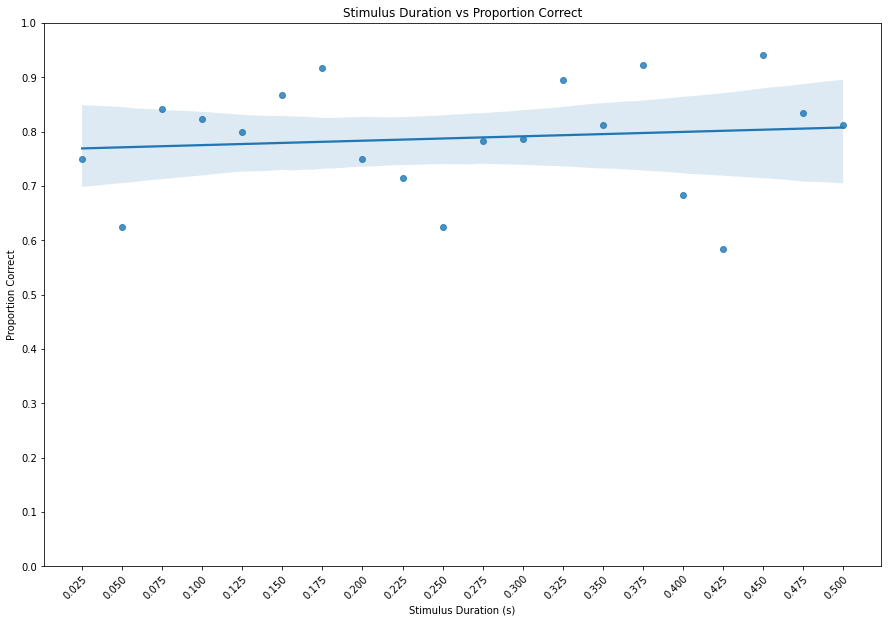

pearson-r: 0.1174716976249817
LinregressResult(slope=0.08099566344293123, intercept=0.7670608449792798, rvalue=0.1174716976249817, pvalue=0.621845776169283, stderr=0.16138934419686574, intercept_stderr=0.048332673215901824)


In [56]:
#duration vs hit rate

print('Number of trials:', len(df.index))

#tally number of each duration and number of correct answers
duration_correct = {}
for i in range(len(clean_df.index)):
    duration = clean_df.iloc[i]['stimulus_duration']
    if duration not in duration_correct:
        duration_correct[duration] = (clean_df.iloc[i]['correct'], 1)
    else:
        duration_correct[duration] = (duration_correct[duration][0] + clean_df.iloc[i]['correct'], duration_correct[duration][1] + 1)

#calculate hit rates for each duration 
duration_correct_prop = {}
for i in duration_correct:
    duration_correct_prop[i] = (duration_correct[i][0])/(duration_correct[i][1])
        
duration_correct_prop = OrderedDict(sorted(duration_correct_prop.items()))
d = list(duration_correct_prop.keys())
c = list(duration_correct_prop.values())

#plot regression between duration and hit rate
fig1, ax1 = plt.subplots(figsize=(15,10))
sns.regplot(x=d, y=c, ax=ax1)
ax1.set_xticks(np.arange(0.025, 0.525, 0.025))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.set_xlabel('Stimulus Duration (s)')
ax1.set_ylabel('Proportion Correct')
ax1.set_title('Stimulus Duration vs Proportion Correct')
plt.show()

#show summary statistics
print('pearson-r:', stat.pearsonr(d, c)[0])
print(stat.linregress(d, c))

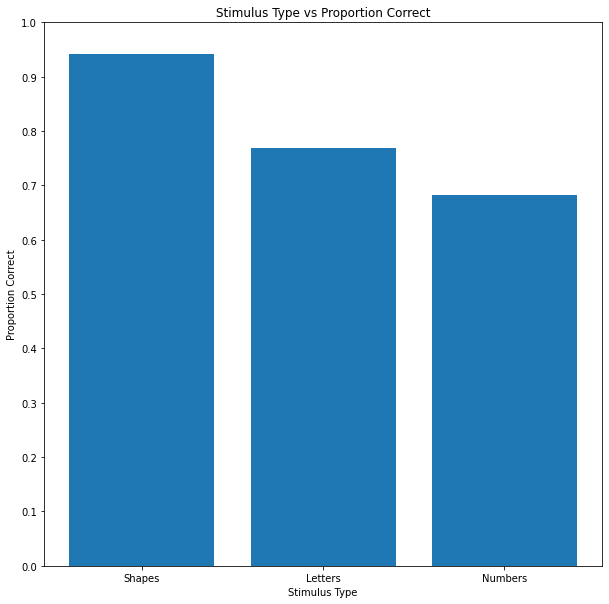

Ind. samples t-test, shape-letter: Ttest_indResult(statistic=3.6972855407575262, pvalue=0.0002754804606383923)
Ind. samples t-test, shape-number: Ttest_indResult(statistic=5.173979991942226, pvalue=4.971237789106244e-07)
Ind. samples t-test,letter-number: Ttest_indResult(statistic=1.52580872288322, pvalue=0.12835264878236893)


In [57]:
#stimulus type vs hit rate

#tally number of each type of trial and number of correct answers
stim_corr = {}
for i in range(len(clean_df.index)):
    stim = clean_df.iloc[i]['actual_answer']
    corr = clean_df.iloc[i]['correct']
    if stim not in stim_corr:
        stim_corr[stim] = (corr, 1)
    else:
        stim_corr[stim] = (stim_corr[stim][0] + corr, stim_corr[stim][1] + 1)
        
#calculate hit rates for each type of stimuli        
stim_corr_prop = {}
for i in stim_corr:
    stim_corr_prop[i] = (stim_corr[i][0])/(stim_corr[i][1])

s = stim_corr_prop.keys()
c = stim_corr_prop.values()

#plot bar graphs
fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.bar(s, c)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_xticks((1, 2, 3), ['Shapes', 'Letters', 'Numbers'])
ax2.set_xlabel('Stimulus Type')
ax2.set_ylabel('Proportion Correct')
ax2.set_title('Stimulus Type vs Proportion Correct')
plt.show()

#ind. samples t-test between stimuli types
shapes = []
letters = []
numbers = []

for i in range(len(clean_df.index)):
    ans = clean_df.iloc[i]['actual_answer']
    corr = clean_df.iloc[i]['correct']
    if ans == 1.0:
        shapes.append(corr)
    elif ans == 2.0:
        letters.append(corr)
    elif ans == 3.0:
        numbers.append(corr)

print('Ind. samples t-test, shape-letter:', stat.ttest_ind(shapes, letters))
print('Ind. samples t-test, shape-number:', stat.ttest_ind(shapes, numbers))
print('Ind. samples t-test,letter-number:', stat.ttest_ind(letters, numbers))